# For defining reaction templates used in polymer fragment generation

# Core Imports

In [1]:
# Custom Imports
from polymerist.rdutils import rdkdraw
from polymerist.rdutils.reactions import reactions
from polymerist.rdutils.amalgamation import portlib

from polymerist.rdutils.smileslib.functgroups import FN_GROUP_TABLE
from polymerist.monomers import specification

# File I/O
from pathlib import Path
import json

# Cheminformatics
from rdkit import Chem
from rdkit.Chem import rdChemReactions

# Static Paths
# RXN_FILES_PATH = Path('rxn_smarts')
RXN_FILES_PATH = Path('rxn_smarts')
RXN_FILES_PATH.mkdir(exist_ok=True)

/home/timber/miniconda3/envs/polymerist_env/lib/python3.11/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/polymerist_env/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/timber/miniconda3/envs/polymerist_env/lib/python3.11/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/polymerist_env/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


## Defining target functional groups

### Locate base SMARTS to build off of

In [2]:
gb = FN_GROUP_TABLE.groupby('group_name')
smarts_keys = {
    'hydroxyl'      : ('Hydroxyl', 156),
    'carboxyl'      : ('Carboxylic acid', 51),
    'carbamate'     : ('Carbamate.', 46),
    'acyl_chloride' : ('Acyl Halide', 237),
    'isocyanate'    : ('Cyanamide', 54),
    'ester'         : ('Ester Also hits anhydrides', 58)
}

smarts_dict, mol_dict = {}, {}
for fn_group_name, (group_key, idx) in smarts_keys.items():
    smarts = gb.get_group(group_key).loc[idx].SMARTS
    rdmol = Chem.MolFromSmarts(smarts)

    print(fn_group_name, smarts)
    # display(rdmol)

    smarts_dict[fn_group_name] = smarts 
    mol_dict[fn_group_name] = rdmol 

hydroxyl [OX2H]
carboxyl [CX3](=O)[OX2H1]
carbamate [NX3,NX4+][CX3](=[OX1])[OX2,OX1-]
acyl_chloride [CX3](=[OX1])[F,Cl,Br,I]
isocyanate [NX3][CX2]#[NX1]
ester [#6][CX3](=O)[OX2H0][#6]


### Define functional groups (with R-group linkers) as basis for desired reactions

phthalimide


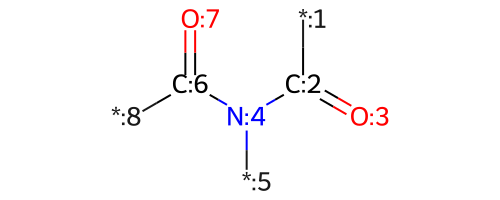

carbamate


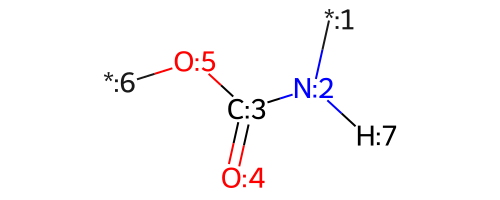

cyclocarbonate


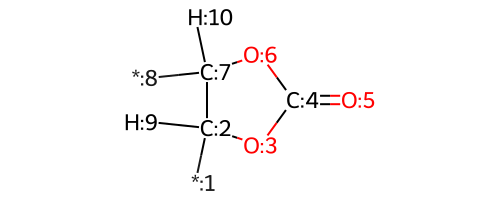

anhydride


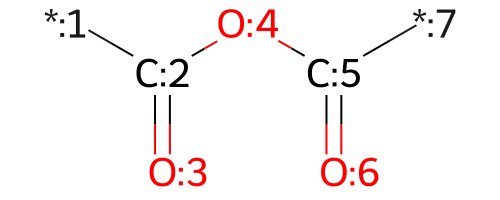

vinyl


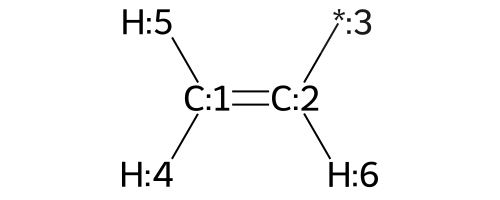

acyl_chloride


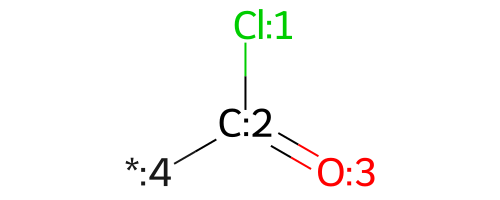

carboxyl


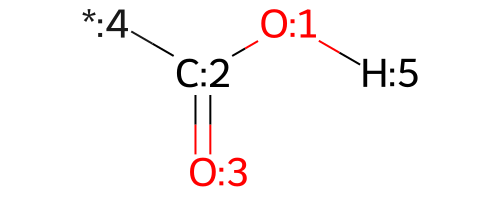

ester


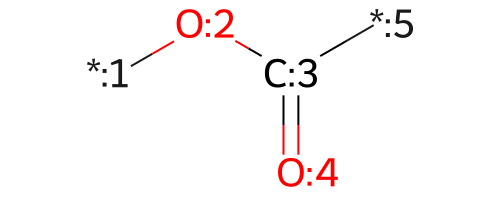

amine


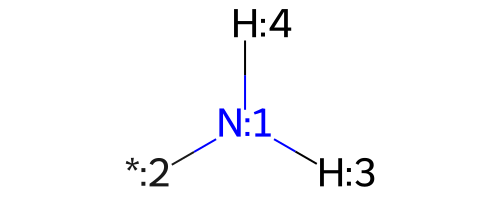

hydroxyl


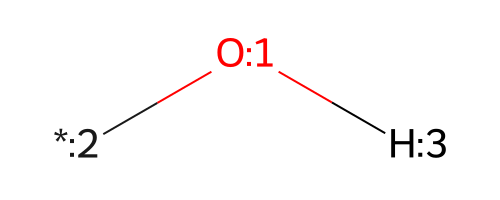

isocyanate


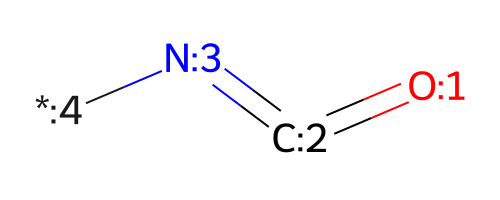

In [3]:
rdkdraw.set_rdkdraw_size(200, 5/2)

fn_group_smiles_bare = { # TODO : add specificity vis-a-vis bond degree and stereo
    'phthalimide'   : '*C(=O)N(*)C(=O)*',
    'carbamate'      : '*[NH]C(=O)O*',
    'cyclocarbonate' : '*C1OC(=O)OC1*',
    'anhydride'      : '*C(=O)OC(=O)*',
    'vinyl'          : 'C=C*',
    'acyl_chloride'  : 'Cl-C(=O)*',
    'carboxyl'       : 'OC(=O)*',
    'ester'          : '*OC(=O)*',
    'amine'          : '[NH2]*',
    'hydroxyl'       : '[OH]*',
    'isocyanate'     : 'O=C=N*',
}

fn_group_smiles, fn_groups = {}, {}
for group_name, smiles in fn_group_smiles_bare.items():
    exp_smiles = specification.expanded_SMILES(smiles, assign_map_nums=True)
    fn_group_mol = Chem.MolFromSmiles(exp_smiles, sanitize=False)
    for atom in fn_group_mol.GetAtoms():
        if portlib.is_linker(atom):
            atom.SetProp('molFileValue', group_name)
            break # ensure this is only set once
    
    print(group_name)
    display(fn_group_mol)

    fn_group_smiles[group_name] = exp_smiles
    fn_groups[      group_name] = fn_group_mol

### Define complete small-molecule byproducts (as query mols)

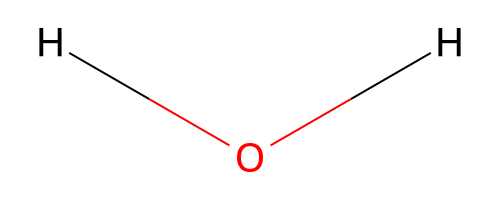

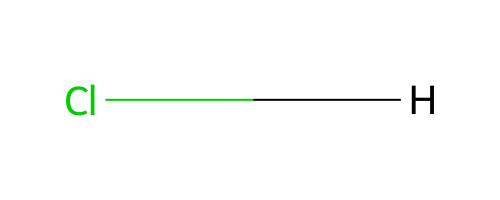

In [4]:
byproduct_smiles_bare = {
    'water' : 'O',
    'hcl'   : '[ClH]'
}

byproduct_smiles, byproducts = {}, {}
for group_name, smiles in byproduct_smiles_bare.items():
    exp_smiles = specification.expanded_SMILES(smiles, assign_map_nums=False)
    byproduct = Chem.MolFromSmarts(exp_smiles) # must be SMARTS for successful query

    byproduct_smiles[group_name] = exp_smiles
    byproducts[group_name] = byproduct
    display(byproduct)

## Export functioal group and byproduct smiles to files

In [5]:
with (RXN_FILES_PATH / 'fn_group_smarts.json').open('w') as file:
    json.dump(fn_group_smiles, file, indent=4)

with (RXN_FILES_PATH / 'byprod_smarts.json').open('w') as file:
    json.dump(byproduct_smiles, file, indent=4)

# Defining polymerization reactions

In [6]:
from polymerist.rdutils.reactions.assembly import ReactionAssembler

rdkdraw.set_rdkdraw_size(400, 3/2)
portlib.Port.bondable_flavors.insert((1, 2)) # allows for specificity when re-bonding cleaved groups


mechanisms : dict[str, ReactionAssembler] = {
    'ester' : ReactionAssembler(
        reactive_groups=(
            fn_groups['hydroxyl'],
            fn_groups['carboxyl'],
        ),
        bond_derangement= {
            1 : (3, 5),
            4 : (5, 3)
        },
        byproducts=[
            byproducts['water']
        ]
    ),
    'amide' : ReactionAssembler(
        reactive_groups=(
            fn_groups['amine'],
            fn_groups['carboxyl'],
        ),
        bond_derangement= {
            1 : (3, 6),
            5 : (6, 3)
        },
        byproducts=[
            byproducts['water']
        ]
    ),
    'imide' : ReactionAssembler(
        reactive_groups=(
            fn_groups['amine'],
            fn_groups['anhydride'],
        ),
        bond_derangement={
            4 : (1, 8),
            6 : (8, 1),
            3 : (1, 8), # doubles up carbonyl transfer - must have target atoms as beginning to maintain canonical derangement form
            9 : (8, 1),
        },
        byproducts=[
            byproducts['water']
        ]
    ),
    'carbonate_phosgene' : ReactionAssembler(
        reactive_groups=(
            fn_groups['hydroxyl'],
            fn_groups['acyl_chloride'],
        ),
        bond_derangement= {
            1 : (3, 5),
            4 : (5, 3)
        },
        byproducts=[
            byproducts['hcl']
        ]
    ),
    'urethane' : ReactionAssembler(
        reactive_groups=(
            fn_groups['isocyanate'],
            fn_groups['hydroxyl'],
        ),
        bond_derangement={
            7 : (5, 3),
            2 : (3, 5)
        }
    ),
    'NIPU' : ReactionAssembler(
        reactive_groups=(
            fn_groups['cyclocarbonate'],
            fn_groups['amine'],
        ),
        bond_derangement= {
            5  : (4, 13),
            11 : (13, 4)
        }
    ),
    'vinyl' : ReactionAssembler(
        reactive_groups=(
            fn_groups['vinyl'],
            fn_groups['vinyl'],
        ),
        bond_derangement= {
            1  : (2, 8),
            10 : (8, 2)
        }
    ),
}

ester {1: (3, 5), 4: (5, 3)}


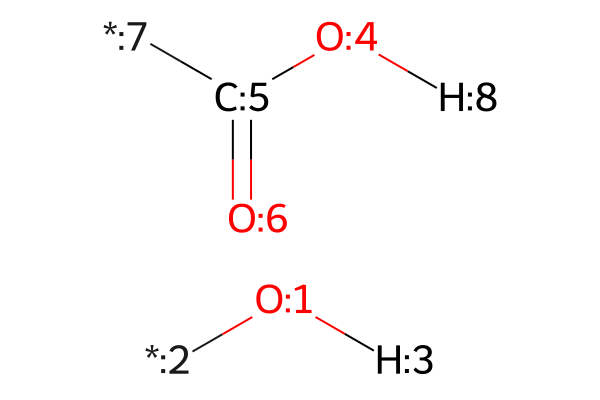

amide {1: (3, 6), 5: (6, 3)}


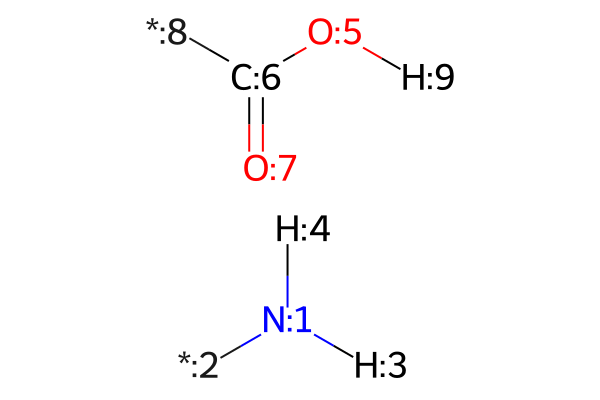

imide {4: (1, 8), 6: (8, 1), 3: (1, 8), 9: (8, 1)}


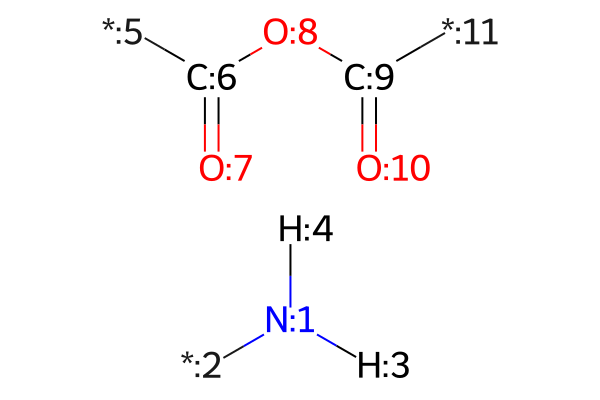

carbonate_phosgene {1: (3, 5), 4: (5, 3)}


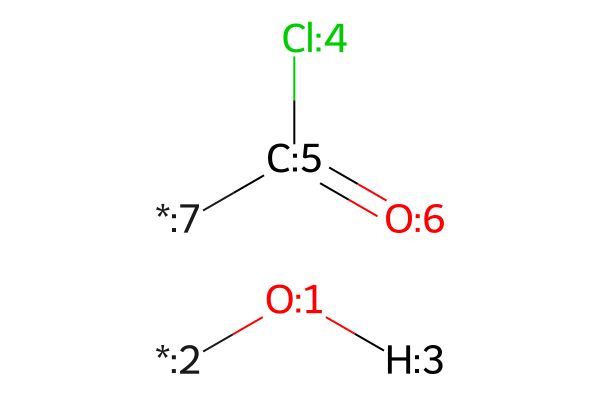

urethane {7: (5, 3), 2: (3, 5)}


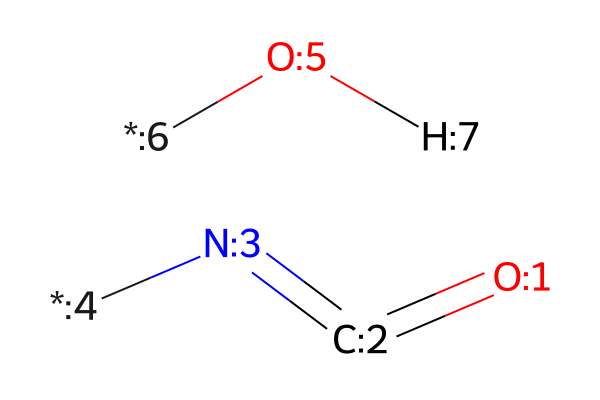

NIPU {5: (4, 13), 11: (13, 4)}


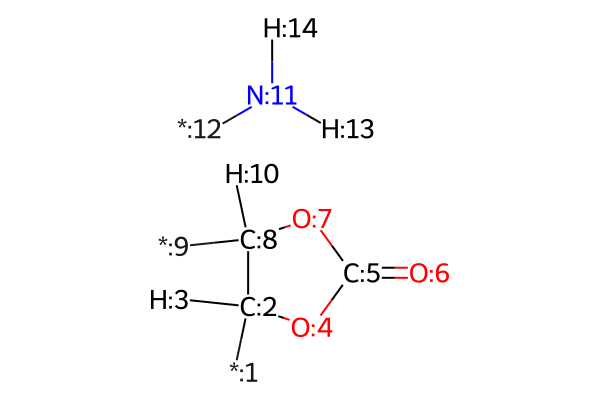

vinyl {1: (2, 8), 10: (8, 2)}


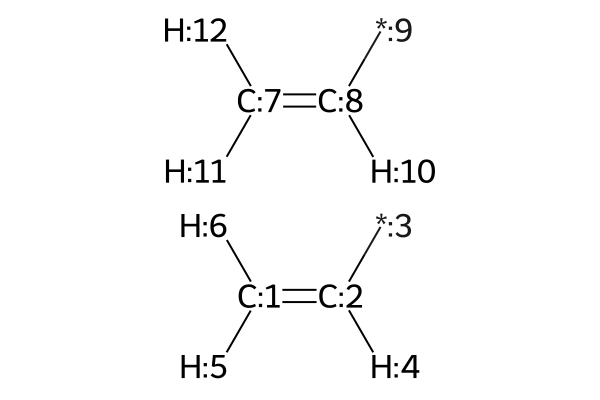

In [7]:
# display mechanism schemata prior to generating reactions (allows for inspection of derangement IDs)
for mech_name, mech_schema in mechanisms.items():
    print(mech_name, mech_schema.bond_derangement)
    display(mech_schema.reactants)

## Generating rxn MDL templates and SMARTS equations and saving to file

In [ ]:
rxns, rxn_smarts = {}, {}
for mech_name, mech_schema in mechanisms.items():
    print(mech_name)
    rxn = mech_schema.assemble_rxn(show_steps=True)
    display(rxn)

    rxns[mech_name] = rxn
    rxn_smarts[mech_name] = rdChemReactions.ReactionToSmarts(rxn)

In [11]:
with (RXN_FILES_PATH / 'rxn_smarts.json').open('w') as file:
    json.dump(rxn_smarts, file, indent=4)

for chemistry, rxn in rxns.items():
    rxn.to_rxnfile(RXN_FILES_PATH / f'{chemistry}.rxn')

# Testing that reaction actually behave as intended

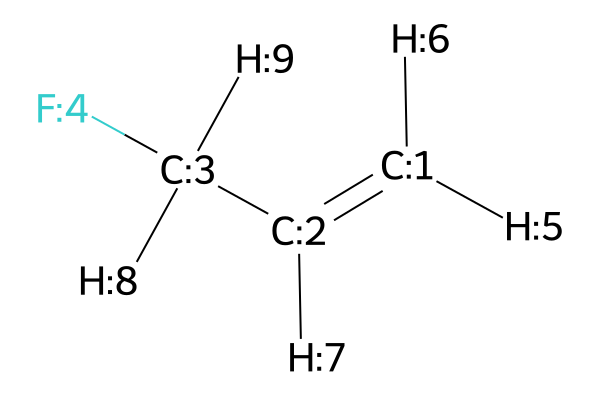

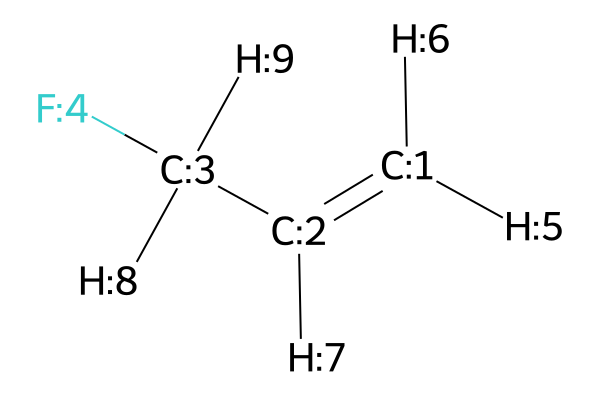

In [12]:
smiles = ('C=C(CF)', 'C=C(CF)') # vinyl
# smiles = ('OCCO', 'ClC(=O)Cl') # carbonate
# smiles = ('OCCO', 'OC(=O)CCC(=O)O') # ester
          
reactants = []        
for sm in smiles:
    exp_smiles = specification.expanded_SMILES(sm)
    reactant = Chem.MolFromSmiles(exp_smiles, sanitize=False)
    display(reactant)
    reactants.append(reactant)

0 0


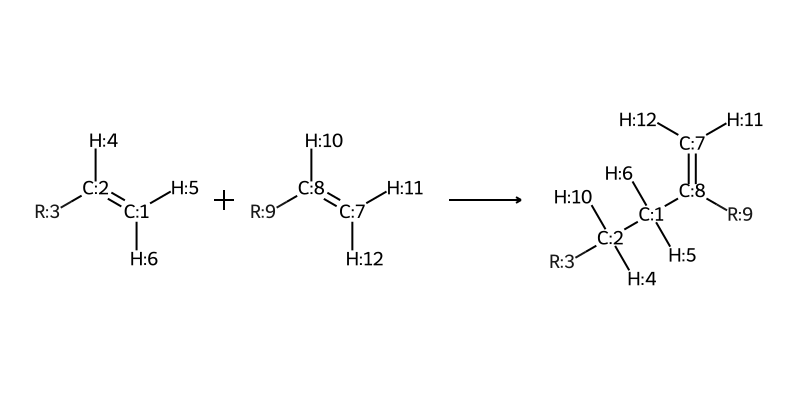

In [13]:
rxn = reactions.AnnotatedReaction.from_rxnfile(RXN_FILES_PATH / 'vinyl.rxn')
rxn.Initialize()
num_warnings, num_errors = rxn.Validate()

print(num_warnings, num_errors)
display(rxn)

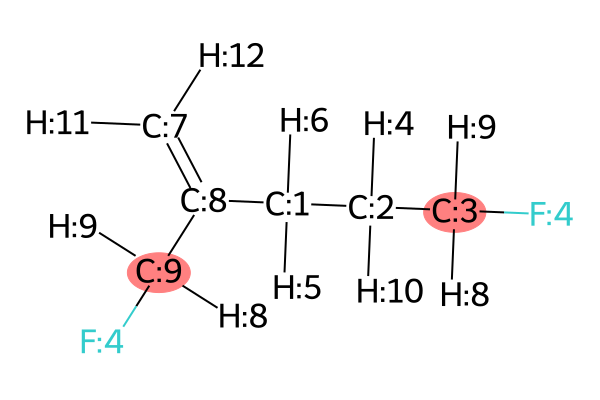

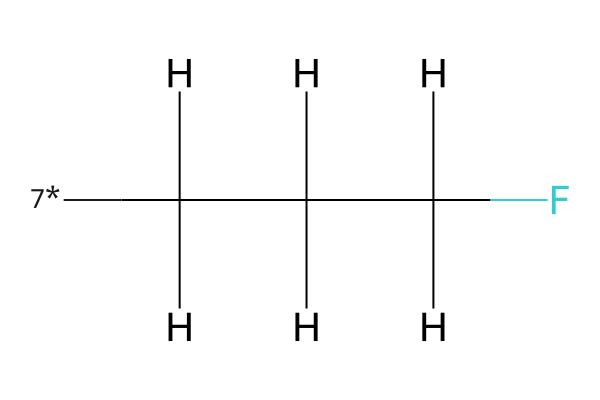

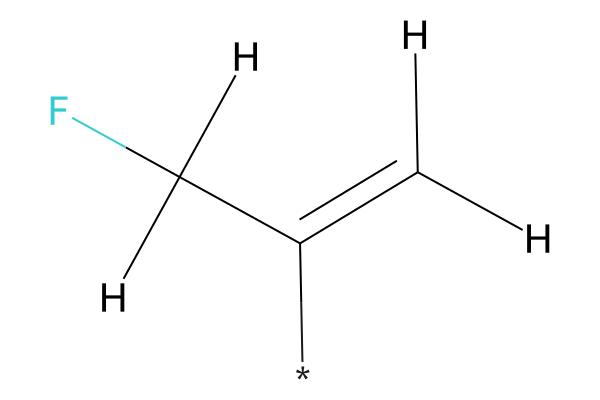

In [14]:
from polymerist.rdutils.reactions import reactors

reactor = reactors.PolymerizationReactor(rxn)
for dimer, frags in reactor.propagate(reactants):
    display(dimer)
    for frag in frags:
        display(frag)
    print('='*50)

# Reverse-engineering example reactions from RDKit

In [ ]:
# rxn = rdChemReactions.ReactionFromRxnFile('test.rxn')
rxn = rdChemReactions.ReactionFromRxnFile('azide.rxn')
nWarn,nError,nReacts,nProds,reactantLabels = rdChemReactions.PreprocessReaction(rxn)
print(reactantLabels)
display(rxn)

In [ ]:
from polymerist.rdutils import rdprops

r1 = rxn.GetReactantTemplate(1)
print(Chem.MolToSmarts(r1))
display(r1)


rdprops.aggregate_atom_prop(r1, 'molFileValue', prop_type=str)